In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns


## Get some database statistics using API

Relevant search field that we will explore are

- report \
serious \
safetyreportid  \
reportercountry - country where the report occured \
senderorganization - name of the organization sending report \
transmissiondate - date the record was created \
qualification - category of individual who submitted report

- patient \
patientonsetage \
patientsex \
reactionmeddrapt - string explaining the reaction

- drug \
medicinalproduct - drug name \
drugindication \
drugcharacterization



In [2]:
url = 'https://api.fda.gov/drug/event.json?'
data = requests.get(url).json()

In [3]:
data

{'meta': {'disclaimer': 'Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.',
  'terms': 'https://open.fda.gov/terms/',
  'license': 'https://open.fda.gov/license/',
  'last_updated': '2022-11-04',
  'results': {'skip': 0, 'limit': 1, 'total': 15600243}},
 'results': [{'safetyreportid': '5801206-7',
   'transmissiondateformat': '102',
   'transmissiondate': '20090109',
   'serious': '1',
   'seriousnessdeath': '1',
   'receivedateformat': '102',
   'receivedate': '20080707',
   'receiptdateformat': '102',
   'receiptdate': '20080625',
   'fulfillexpeditecriteria': '1',
   'companynumb': 'JACAN16471',
   'primarysource': {'reportercountry': 'CANADA', 'qualification': '3'},
   'sender': {'senderorganization': 'FDA-Public Use'},
   'receiver': None,
   'patient': {'patientonseta

## Amount of reports over years

In [4]:
url = 'https://api.fda.gov/drug/event.json?count=receiptdate'
data = requests.get(url).json()
df_time = pd.DataFrame(data.get("results"))
df_time.head()

,time,count
0,00901102,1
1,10100526,1
2,19080729,1
3,19190215,1
4,19281116,1


In [5]:
df_time = df_time.assign(time = pd.to_datetime(df_time.time, format=f"%Y%m%d", errors='coerce'))
df_time = df_time.dropna()
df_time.time = df_time.time.astype('datetime64[M]')

In [6]:
#select data from 2000 to 20003

dt_old = pd.Timestamp('2004-1-1')
dt_now = pd.Timestamp.now()

df_time=df_time[(df_time.time>dt_old)&(df_time.time<dt_now)]

<AxesSubplot: xlabel='date'>

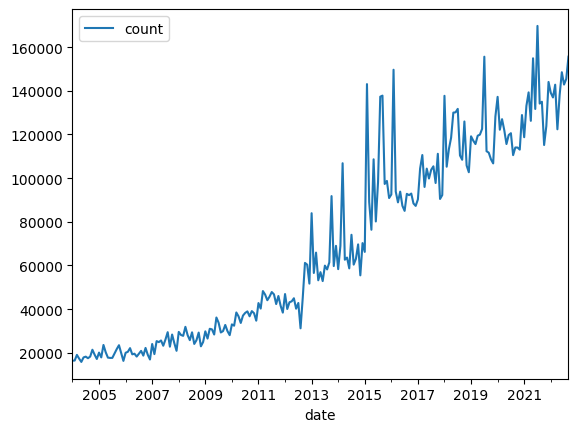

In [7]:
df_time = df_time.assign(month_year = df_time.time.dt.to_period('M'))
df_time_aux = df_time.groupby('month_year')['count'].sum().reset_index()
df_time_aux.plot(x='month_year', y='count', xlabel='date')

## Countries representation

In [10]:
url = 'https://api.fda.gov/drug/event.json?count=occurcountry.exact'
data = requests.get(url).json()
df_countries = pd.DataFrame(data.get("results"))
df_countries.head()

,term,count
0,US,8744571
1,CA,452068
2,GB,394012
3,JP,359842
4,FR,355787


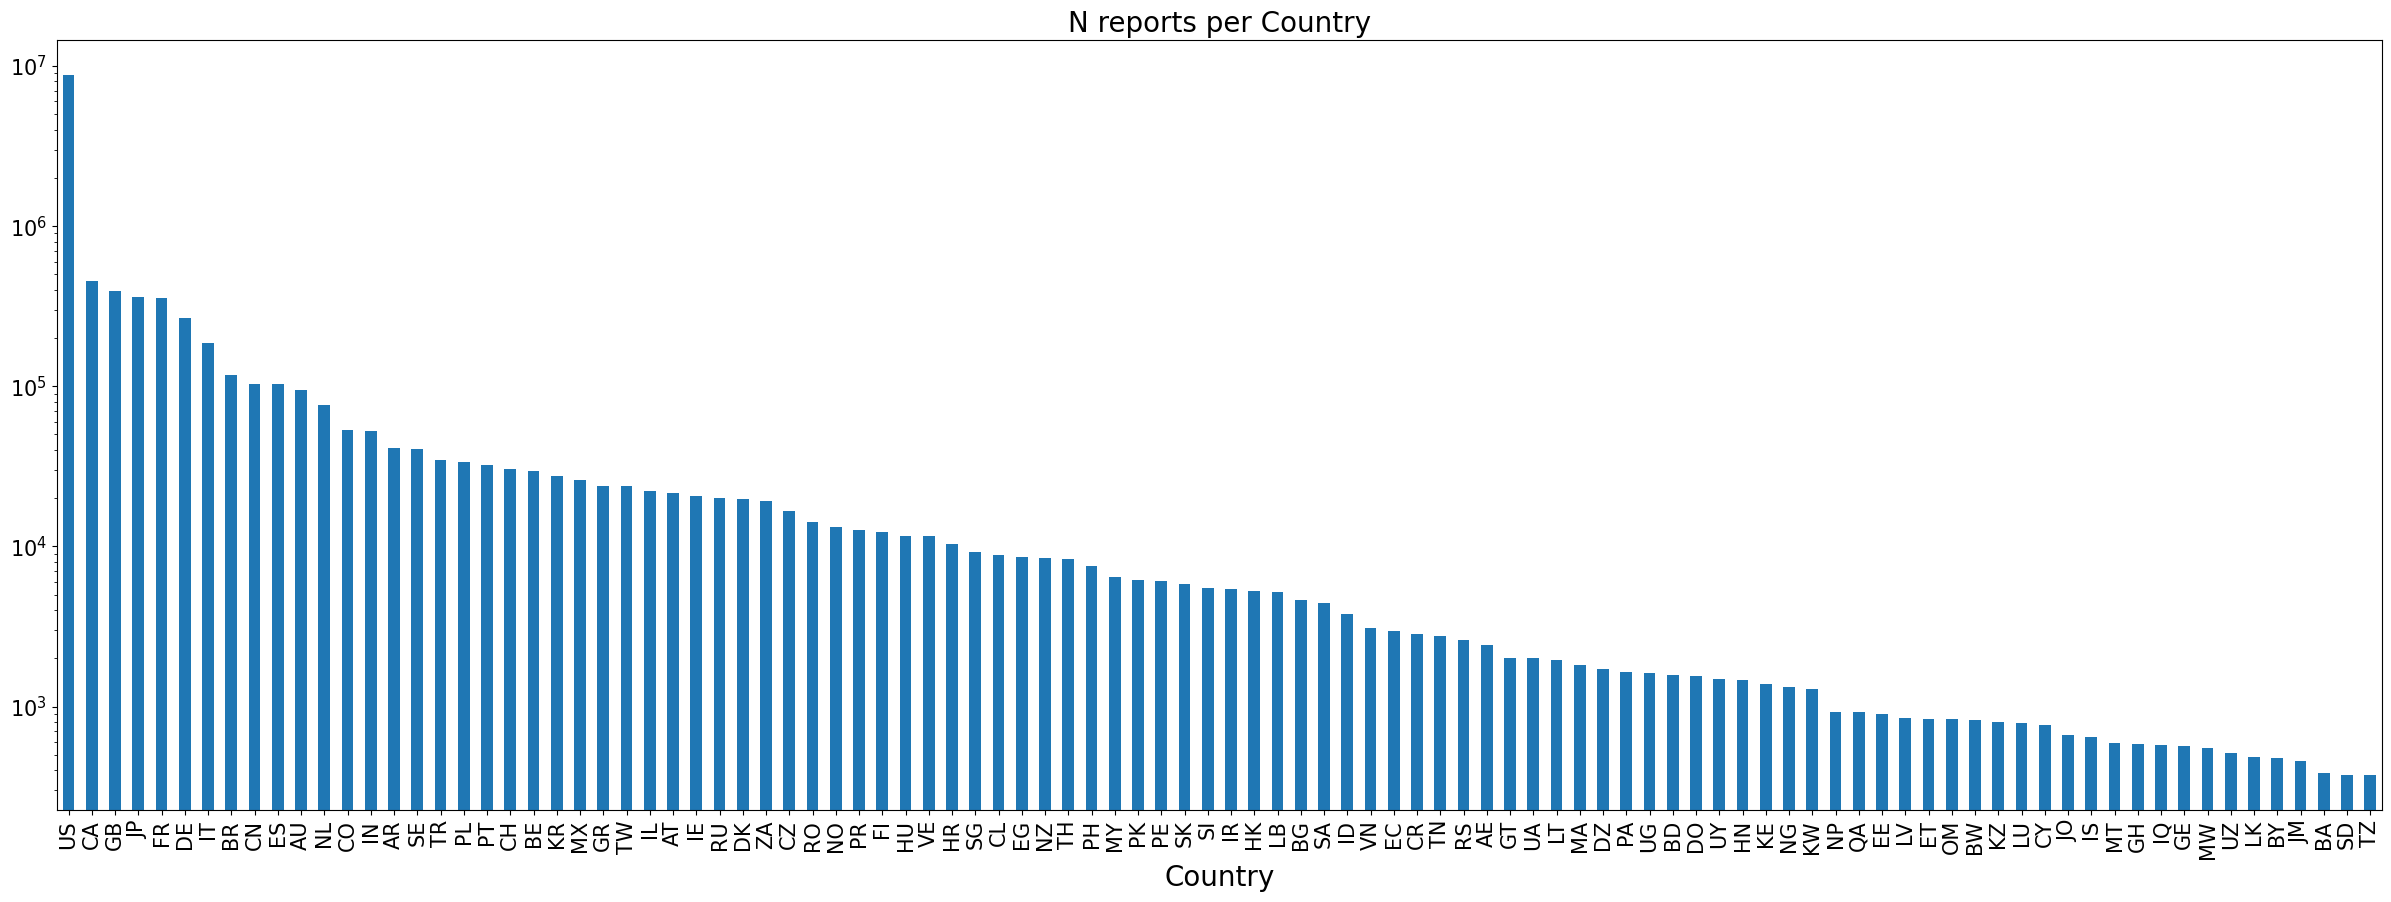

In [11]:
ax = df_countries.plot(kind='bar', x='term', y='count',figsize=(30, 10), logy=True, fontsize=15, xlabel='country', legend=False)
ax.set_xlabel('Country', fontsize=20);
ax.set_title('N reports per Country', fontsize=20);

Seems that most of the records come from the USA (note the logaritmics y scale).
Let's get the most reported adverse effects for each conutry

## Adverse events occuriencies

In [14]:
url = 'https://api.fda.gov/drug/event.json?count=patient.reaction.reactionmeddrapt.exact'
data = requests.get(url).json()
df_adv = pd.DataFrame(data.get("results"))
df_adv.head()

,term,count
0,DRUG INEFFECTIVE,986529
1,DEATH,640323
2,NAUSEA,600121
3,FATIGUE,574429
4,OFF LABEL USE,514112


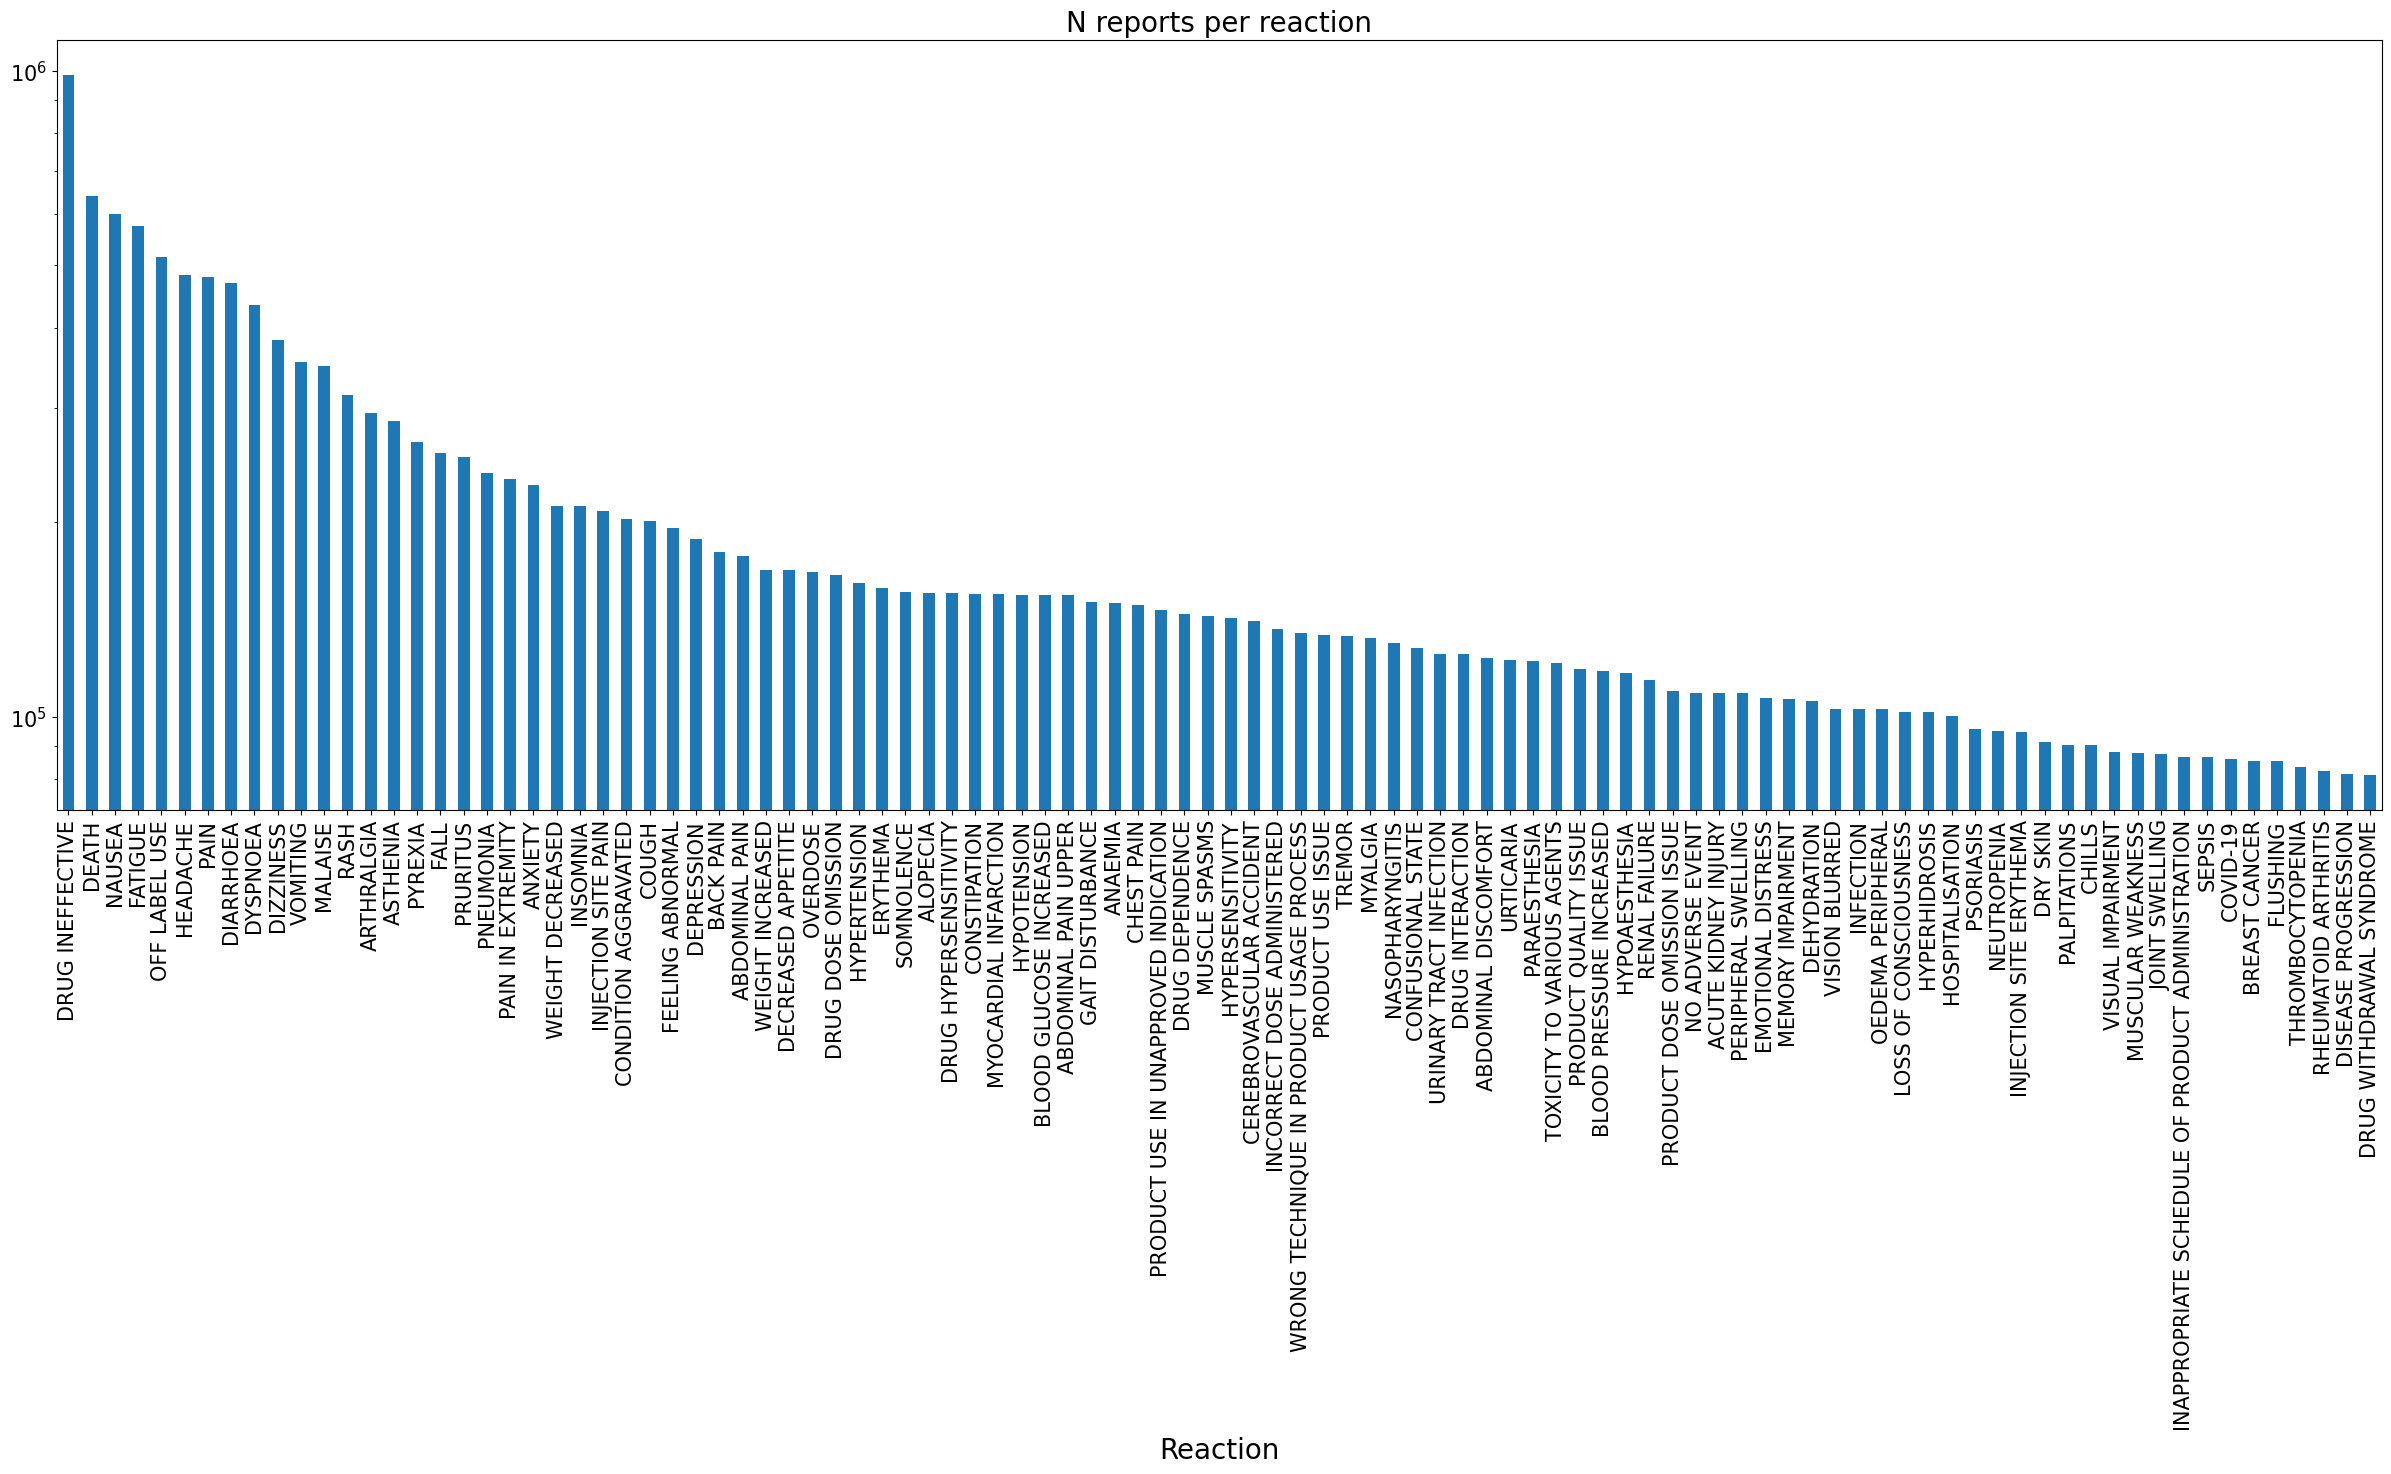

In [15]:
ax = df_adv.plot(kind='bar', x='term', y='count',figsize=(30, 10), logy=True, fontsize=15, xlabel='reaction', legend=False)
ax.set_xlabel('Reaction', fontsize=20);
ax.set_title('N reports per reaction', fontsize=20);

## Examine patientsex, patientage, serious

In [23]:
df_tmp.term.replace({0:'Unknown', 1:'Male', 2:'Female'})

0     Female
1       Male
2    Unknown
Name: term, dtype: object

In [25]:
df_tmp

,term,count
0,2,8408499
1,1,5472808
2,0,93409


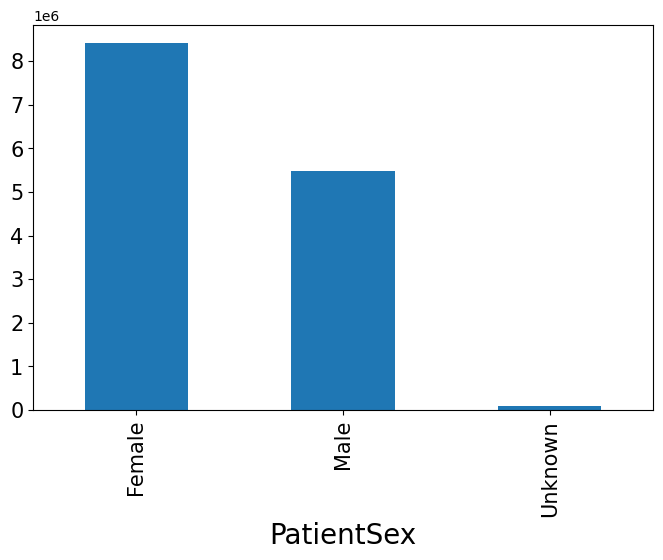

In [28]:

url = 'https://api.fda.gov/drug/event.json?count=patient.patientsex'
data = requests.get(url).json()
df_tmp = pd.DataFrame(data.get("results"))
df_tmp.term = df_tmp.term.replace({0:'Unknown', 1:'Male', 2:'Female'})
ax = df_tmp.plot(kind='bar', x='term', y='count',figsize=(8, 5), fontsize=15, xlabel='patientsex', legend=False)
ax.set_xlabel('PatientSex', fontsize=20);


There seem to be more reports for Females compared to Males; it might be related to gender- specific conditon (ie pregnancy) or indeed more pronounced adverse effects on females

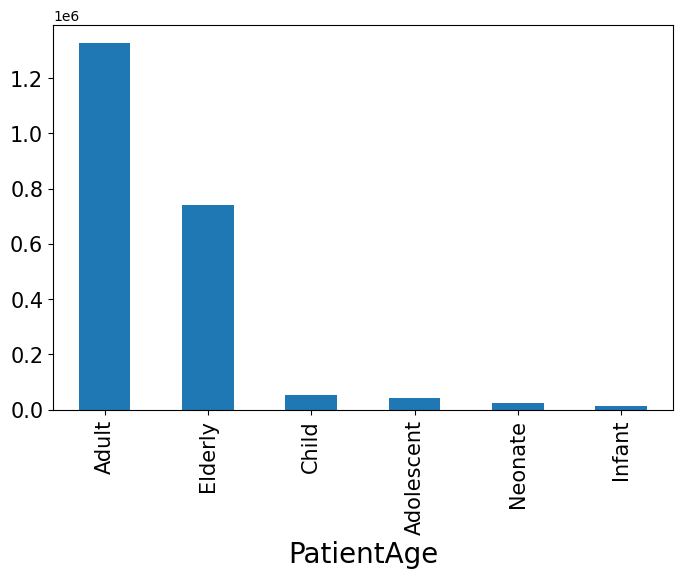

In [37]:
agemap = {1:'Neonate',
          2: 'Infant',
          3: 'Child',
          4: 'Adolescent',
          5: 'Adult',
          6: 'Elderly'}

url = 'https://api.fda.gov/drug/event.json?count=patient.patientagegroup'
data = requests.get(url).json()
df_tmp = pd.DataFrame(data.get("results"))
df_tmp.term = df_tmp.term.replace(agemap)
ax = df_tmp.plot(kind='bar', x='term', y='count',figsize=(8, 5), fontsize=15, xlabel='patientage', legend=False)
ax.set_xlabel('PatientAge', fontsize=20);

Most of the database consists of adults and elderly reports, it might be due to different medications taken in different age, or that adults/elderly are simply taking more medicines in general

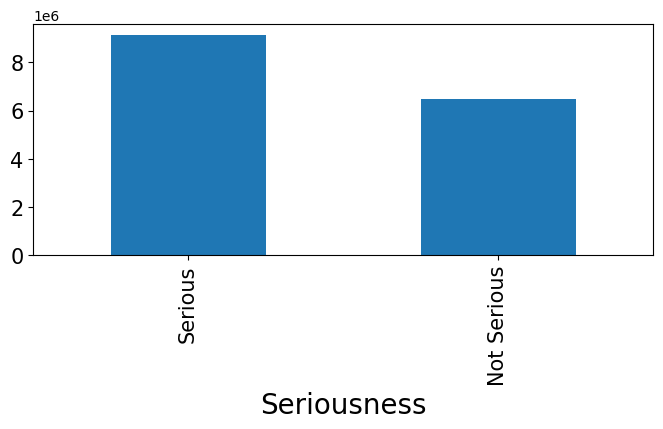

In [39]:
seriousmap = {1:'Serious',
              2: 'Not Serious'}
url = 'https://api.fda.gov/drug/event.json?count=serious'
data = requests.get(url).json()
df_tmp = pd.DataFrame(data.get("results"))
df_tmp.term = df_tmp.term.replace(seriousmap)
ax = df_tmp.plot(kind='bar', x='term', y='count',figsize=(8, 3), fontsize=15, legend=False)
ax.set_xlabel('Seriousness', fontsize=20);

## Check if different countries report different adverse reaction

In [170]:
def make_df_per_country(countr):
    url = f'https://api.fda.gov/drug/event.json?search=occurcountry:"{countr}".exact&count=patient.reaction.reactionmeddrapt.exact&limit=10'
    data = requests.get(url).json()
    tmp_df = pd.DataFrame(data.get("results"))
    return tmp_df.assign(country=countr)

In [171]:
df_countries.set_index('term', inplace=True)

KeyError: "None of ['term'] are in the columns"

In [172]:
df_countr_ev = pd.concat([make_df_per_country(x) for x in  df_countries.index.values[:10]], ignore_index=True)

In [173]:
df_countr_ev.head()

,term,count,country
0,DRUG INEFFECTIVE,665412,US
1,FATIGUE,336639,US
2,OFF LABEL USE,325713,US
3,DEATH,322895,US
4,NAUSEA,316738,US


In [174]:
sum_per_count = df_countr_ev.groupby('country',group_keys=True)['count'].sum().reset_index()
sum_per_count.columns = ['country', 'tot_per_count'] 
df_countr_ev = df_countr_ev.merge(sum_per_count, on='country', how='left')
df_countr_ev = df_countr_ev.assign(norm_cout = df_countr_ev['count']/df_countr_ev['tot_per_count'])

In [175]:
df_countr_ev = df_countr_ev.sort_values('tot_per_count', ascending=False)

In [176]:
countries_sorted = sum_per_count.sort_values('tot_per_count', ascending=False)['country'].values

In [177]:
#for each contry plot only 10 most frequent events
g = df_countr_ev.groupby('country', group_keys=False)
g = g.apply(lambda x: x.sort_values('norm_cout', ascending=False).head(10))

In [178]:
ev_count_count = pd.crosstab(g.term, g.country, values=g['norm_cout'], aggfunc='sum')

In [179]:
ev_count_count.head()

country,BR,CA,CN,DE,ES,FR,GB,IT,JP,US
term,,,,,,,,,,
ACUTE KIDNEY INJURY,NaN,NaN,NaN,NaN,0.089597,0.147635,NaN,NaN,NaN,NaN
ANAEMIA,NaN,NaN,NaN,NaN,0.075926,NaN,NaN,0.084068,0.091197,NaN
ARTHRALGIA,NaN,0.085836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ASTHENIA,0.076890,NaN,NaN,NaN,0.080473,0.085682,NaN,0.097674,NaN,NaN
DEATH,0.106086,0.078240,0.200117,0.078436,0.067847,NaN,0.145491,NaN,0.092045,0.101323


In [180]:
ev_count_count = ev_count_count.fillna(0)

In [181]:
ev_count_count = ev_count_count[countries_sorted]

In [182]:
ev_count_count.shape


(35, 10)

(-0.5, 12.5)

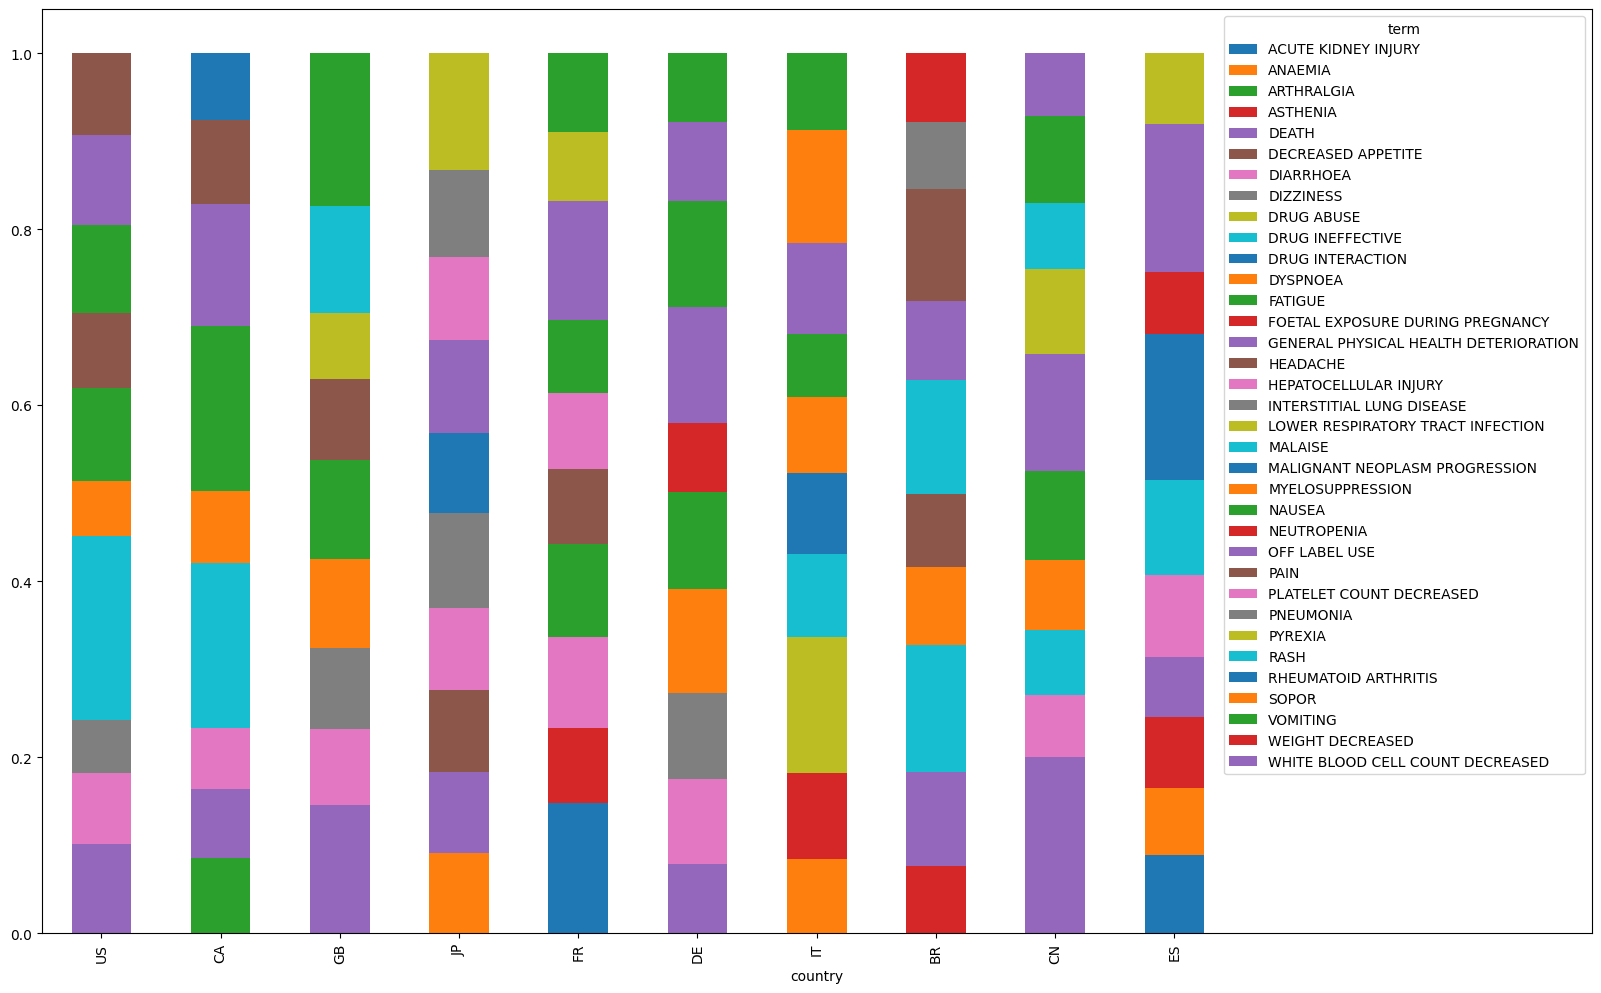

In [183]:
ax = ev_count_count.T.plot(kind='bar', stacked=True, figsize=(20,12))
ax.get_xlim()
ax.set_xlim(-0.5, 12.5)

Seems FR and IT are te safest when it comes to DEATH adverse effect :)

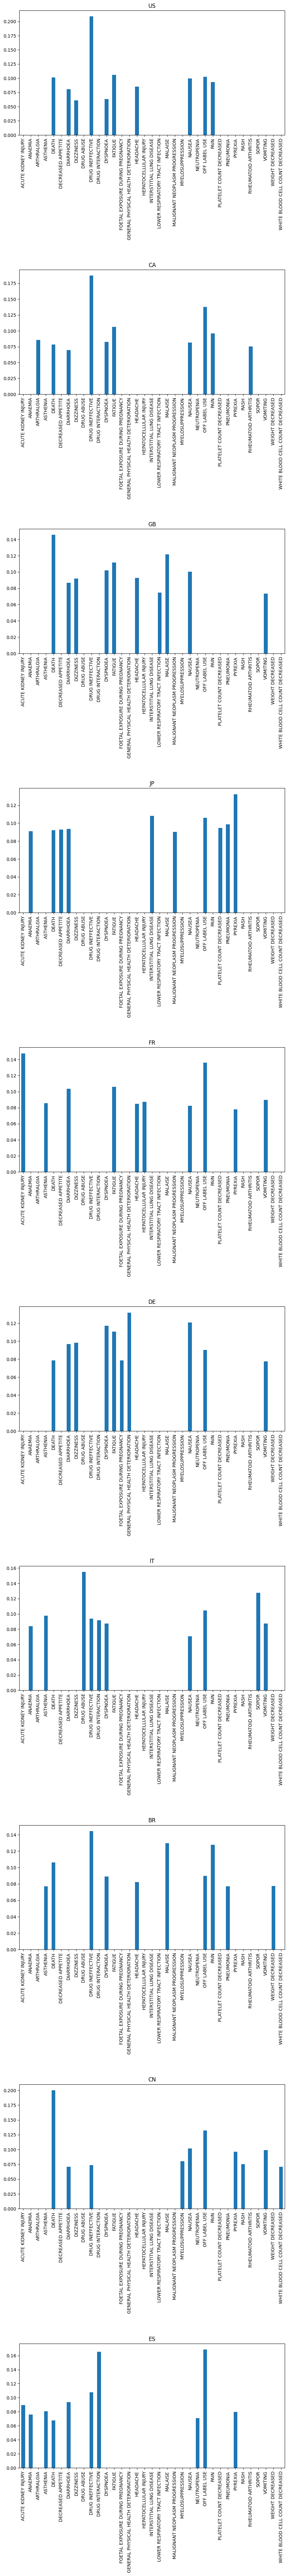

In [189]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(10, 80))
for indx, col in  enumerate(ev_count_count.columns):
    ax = axs[indx]
    group = ev_count_count[col]
    group.plot(ax=ax, kind='bar', x='term')
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_title(col)
fig.tight_layout(pad=5.0)